In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
sbn.set(style='white', font_scale=1.5)
%matplotlib inline

import zipfile
import re
import glob
import os

In [2]:
files = sorted(glob.glob('*.zip'))
out = []
for fname in files:
    foldername = fname.replace('.zip', '')
    readname   = fname.replace('_fastqc.zip', '.txt.gz')
    mb = os.path.getsize(readname)/1024/1024
    with zipfile.ZipFile(fname, 'r') as handle:
        r = handle.open((foldername+'/fastqc_data.txt'), 'r')
        reg = re.search('^([^\_]+)_.+Index(BC[0-9]+).+', fname)
        
        print(reg.group(1), reg.group(2))
        meanq=[]
        for l in r:
            l = l.decode('utf-8').rstrip('\n')
            nrreg = re.compile('Total.+([0-9]+).+')
            if nrreg.match(l):
                #print(l)
                numread = int(l.split('\t')[-1])
                #print(numread)
            elif re.match('^\#Base', l):
                
                for i in range(51):
                    m = (next(r).decode('utf-8').rstrip('\n').split('\t')[1])
                    if 'nan' in m:
                        print(m)
                    meanq.append(float(m))
                break
        #print(meanq[-5:])
    out.append({'name': (reg.group(1) + '_' + reg.group(2)),
                'throughput' : numread,
               'meanq': meanq,
            'filesize': mb})


HiSeq1500 BC1
HiSeq1500 BC2
HiSeq1500 BC3
HiSeq1500 BC4
HiSeq1500 BC5
HiSeq1500 BC6
HiSeq1500 BC7
HiSeq1500 BC8
Marko BC1
Marko BC2
Marko BC3
Marko BC4
Marko BC5
Marko BC6
Marko BC7
Marko BC8


In [3]:
dfout = pd.DataFrame(out)
dfout

,filesize,meanq,name,throughput
0,1942.283854,"[31.660284146443203, 31.846580365339545, 31.87...",HiSeq1500_BC1,51674833
1,2000.799457,"[31.615469166537398, 31.801801968803492, 31.83...",HiSeq1500_BC2,53190377
2,1811.666269,"[31.597205434186584, 31.785403578397652, 31.81...",HiSeq1500_BC3,48316486
3,1921.925798,"[31.648907392878424, 31.83867489592395, 31.864...",HiSeq1500_BC4,50612749
4,1841.477521,"[31.66242755777886, 31.84791881528226, 31.8778...",HiSeq1500_BC5,48836679
5,1948.806469,"[31.65503973946051, 31.838317650130563, 31.874...",HiSeq1500_BC6,50498295
6,2066.814597,"[31.706940756935623, 31.889651074376914, 31.92...",HiSeq1500_BC7,52972378
7,2264.531556,"[31.68351331739378, 31.869561182174774, 31.896...",HiSeq1500_BC8,57849382
8,380.636765,"[32.80202247598766, 32.82280550653862, 32.8333...",Marko_BC1,19399192
9,356.061379,"[32.7986162764498, 32.819719947298324, 32.8303...",Marko_BC2,18391824


# Mean quality score in fastq files

This is a HiSeq read output of 50-bp in length for each raw read. The average of basepair quality within sample is almost always above quality score 30, which has an error probability lower than 0.001. Therefore, the read quality is good.

I also notice that there is a clear cutoff of quality score across samples. This suggests that the data has been trimmed and quality checked. 

Text(0.5,29,'Position in read (bp)')

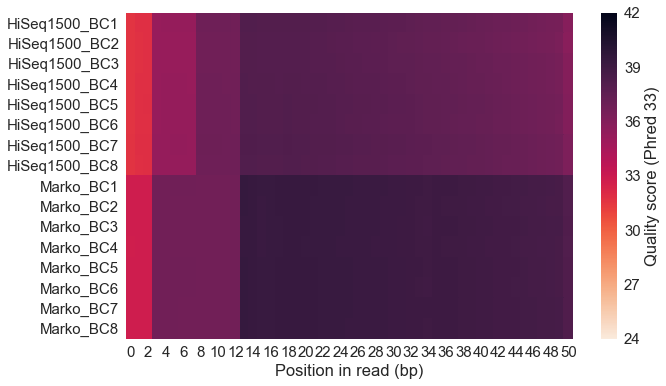

In [4]:
mask = dfout['meanq'].isnull()
fig, ax = plt.subplots(1,1, figsize=(10,6))
sbn.heatmap(np.asarray(list(dfout['meanq']), dtype=float), 
            linewidths=0, cmap=sbn.cm.rocket_r, ax=ax, 
            yticklabels=dfout['name'], vmin=24, vmax=42,
            cbar_kws={'label': 'Quality score (Phred 33)'})
ax.set_xlabel('Position in read (bp)')

# The file size is positively correlated with read throughput in each sample

The samples named 'Marko....' have smaller file size is majorly due to the lower throughput in those files compared with read files 'HiSeq1500_160323_AH2G7HADXY....'

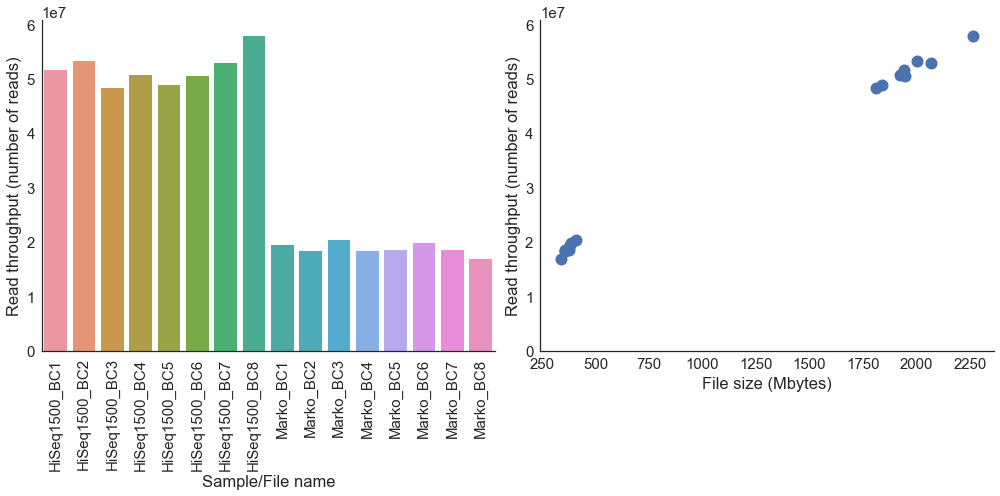

In [5]:
fig, axes = plt.subplots(1,2, figsize=(14,7))

sbn.barplot(x=dfout['name'], y=dfout['throughput'], ax= axes[0])
axes[0].set_xlabel('Sample/File name')
axes[0].set_ylabel(r'Read throughput (number of reads)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

axes[1].plot(dfout['filesize'], dfout['throughput'], 'o', linestyle='None', markersize=12)
axes[1].set_ylabel(r'Read throughput (number of reads)')
axes[1].set_xlabel('File size (Mbytes)')
axes[1].set_ylim(axes[0].get_ylim())

sbn.despine() 
fig.tight_layout()